In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sys.path.append('../src')
from base import buildmethod, checkmethod, HotTopic
from qae import QAE
from nets import OPTIM, MLP, VAE
from sim import make_dataset
from utils import get_kwargs, show_dataset, shuffle

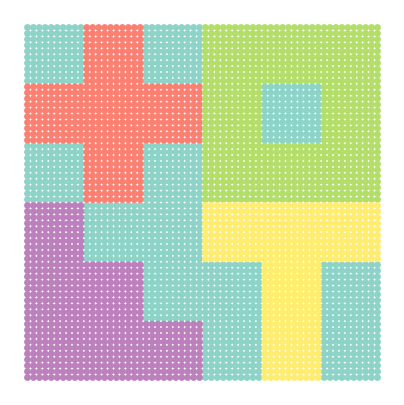

In [2]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

VAE: 100%|██████████| 200/200 [00:10<00:00, 18.49it/s]


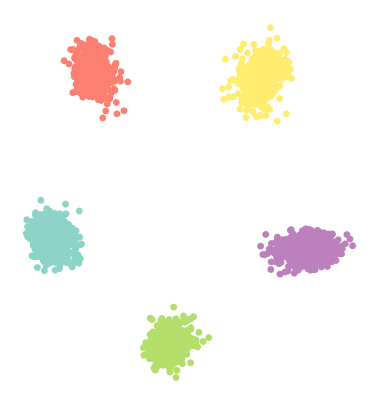

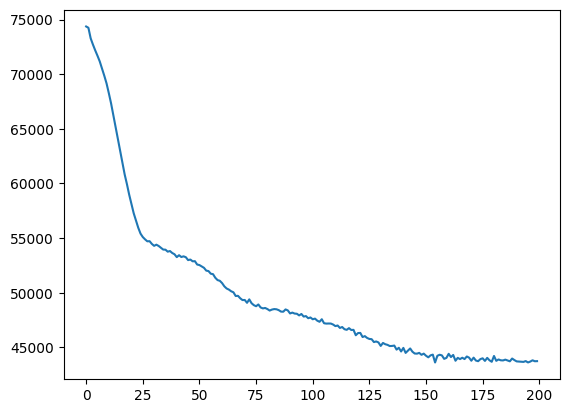

In [3]:
model = VAE(channels=(64, 2))
z = model.fit_transform(data[:, 3:])
show_dataset(z, labels, sectioned=False)
plt.show()
plt.plot(range(len(model.log_)), model.log_)
plt.show()